<a href="https://colab.research.google.com/github/jeonghojo00/ImageCaptioning/blob/main/ImgCaptioning_Transformer_flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Initialization

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mount='/content/drive'
drive_root = mount + "/MyDrive/Colab Notebooks/ImageCaptioning/"
%cd $drive_root

/content/drive/MyDrive/Colab Notebooks/ImageCaptioning


In [3]:
import sys
import subprocess
import pkg_resources

required = {'efficientnet_pytorch', 'timm', 'tqdm', 'torch', 'torchvision', 'datasets', 'sacrebleu'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [4]:
# Import Libraries
import os
from PIL import Image
from tqdm import tqdm
import pickle
import nltk
from collections import Counter
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch.optim as optim 
from torchvision import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from load_data import *
from resize_image import *
from split_caption import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#1. Preparation of Images (Train/Val/Test split)
Split Flickr8k dataset into train, validation, and test set for both images and captions

## 1.1 Preprocess images

In [5]:
# Define data folder
image_dir = './data/flickr8k/Images'
caption_path = './data/flickr8k/captions.txt' # Original caption file with path

train_image_dir = './data/flickr8k/train/Images' # Resized train images folder
val_image_dir = './data/flickr8k/val/Images' # Resized validation images folder
test_image_dir = './data/flickr8k/test/Images' # Resized test images folder
train_caption_path = "./data/flickr8k/train/captions.txt" # Resized train images' captions
val_caption_path = "./data/flickr8k/val/captions.txt" # Resized validation images' captions
test_caption_path = "./data/flickr8k/test/captions.txt" # Resized test images' captions
num_train_images = 6000
num_val_images = 1000


vocab_path = "./vocab.pkl" # vocabulary file
word_threshold = 4 # Minimum occurrances of words

resizeImage_required = False
if resizeImage_required == True:
    save_resized_images(image_dir, train_image_dir, val_image_dir, test_image_dir, num_train_images, num_val_images, resize_size=None)

## 1.2 Preprocess captions for vocab dictionary and caption divisions

In [6]:
splitCaption_required = False

if splitCaption_required == True:
    split_caption(caption_path, train_caption_path, val_caption_path, test_caption_path, vocab_path, num_train_images, num_val_images, word_threshold)

In [7]:
# Number of Traning data
!wc -l ./data/flickr8k/train/captions.txt
# Number of Validation data
!wc -l ./data/flickr8k/val/captions.txt
# Number of Testing data!wc -l ./data/flickr8k/test/captions.txt

30000 ./data/flickr8k/train/captions.txt
5000 ./data/flickr8k/val/captions.txt


#2. Dataset and Dataloader
Define functions to load dataset and dataloader

In [8]:
# Include caplen
import string
import spacy

spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary(object):
    def __init__(self, freq_threshold):
        self.stoi = {}
        self.itos = {}
        self.idx = 0
        self.freq_threshold = freq_threshold

    def add_word(self, word):
        if not word in self.stoi:
            self.stoi[word] = self.idx
            self.itos[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.stoi:
            return self.stoi['<UNK>']
        return self.stoi[word]

    def __len__(self):
        return len(self.stoi)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentences):
        counter = Counter()
        for caption in sentences:
            caption = caption.translate(str.maketrans('', '', string.punctuation)).strip()
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens) # 각 토큰의 개수 세기

        words = [word for word, cnt in counter.items() if cnt >= self.freq_threshold]

        self.add_word('<PAD>')
        self.add_word('<SOS>')
        self.add_word('<EOS>')
        self.add_word('<UNK>') # unknown 토큰

        # Vocabulary 객체에 모든 단어를 담기
        for word in words:
            self.add_word(word)
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
class FlickrDataset(Dataset):
    def __init__(self, root_dir='./data/flickr8k/Images', caption_path='./data/flickr8k/captions.txt', 
                 data_split='train', vocab_path="./data/flickr8k/train/vocab.pkl", 
                 freq_threshold=10, max_cap_len = 50, transform=None):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
        self.data_split = data_split
    
        self.df = pd.read_csv(caption_path, names=['image', 'caption'])
        self.captions = self.df['caption']
        self.images = self.df['image']
        self.max_cap_len = max_cap_len
        
        # When we make train dataset and its loader, we build a new vocab. Otherwise, load from the pre-defined vocab
        if self.data_split == "train":
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.captions.tolist())
            with open(vocab_path, 'wb') as f:
                pickle.dump(self.vocab, f)
        else:
            df2 = self.df.groupby('image').agg({'caption': lambda x: list(x)}).rename(columns = {'caption': 'all_captions'})
            self.merged_df = pd.merge(self.df, df2, on='image')
            self.allcaptions = self.merged_df['all_captions']            
            with open(vocab_path, 'rb') as f:
                self.vocab = pickle.load(f)

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        c = self.vocab.tokenizer_eng(caption.translate(str.maketrans('', '', string.punctuation)).strip())
        numericalized_caption = [self.vocab.stoi['<SOS>']] + \
                                [self.vocab.stoi.get(word, self.vocab.stoi['<UNK>']) for word in c] + \
                                [self.vocab.stoi['<EOS>']] + \
                                [self.vocab.stoi['<PAD>']] * (self.max_cap_len - len(c))
        caplen = len(c)+2
        
        if self.data_split == 'train':
            return img, torch.LongTensor(numericalized_caption), [caplen]
        else:
            captionsPerImage = self.allcaptions[index]
            allcaptions_list = list()
            for cap in captionsPerImage:
                c = self.vocab.tokenizer_eng(cap.translate(str.maketrans('', '', string.punctuation)).strip())
                indexed_caption = [self.vocab.stoi['<SOS>']] + \
                                    [self.vocab.stoi.get(word, self.vocab.stoi['<UNK>']) for word in c] + \
                                    [self.vocab.stoi['<EOS>']] + \
                                    [self.vocab.stoi['<PAD>']] * (self.max_cap_len - len(c))
                allcaptions_list.append(indexed_caption)  
            return img, torch.LongTensor(numericalized_caption), [caplen], torch.LongTensor(allcaptions_list)

def collate_fn_caplen(batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    img = torch.cat(imgs, dim=0)
    captions = [item[1].unsqueeze(0) for item in batch]
    caption = torch.cat(captions, dim=0)
    caplens = [item[2] for item in batch]
    try:
        allcaptions = [item[3].unsqueeze(0) for item in batch]
        allcaption = torch.cat(allcaptions, dim=0)
        return img, caption, torch.LongTensor(caplens), allcaption
        
    except:
        return img, caption, torch.LongTensor(caplens)

        
def getLoader(root_dir="./data/flickr8k/train/Images", caption_path="./data/flickr8k/train/captions.txt", data_split = "train", vocab_path = "./data/flickr8k/train/vocab.pkl", word_frequency=5, max_cap_len=50, transform=None, batch_size=32, num_workers=0, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,
                            caption_path=caption_path, 
                            data_split=data_split,
                            vocab_path=vocab_path,
                            freq_threshold=word_frequency, 
                            max_cap_len=max_cap_len, 
                            transform=transform)
    vocab = dataset.vocab
    loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True, collate_fn=collate_fn_caplen)
    return loader, dataset     

tensor([16])
tensor([  1,  46,  47,  31, 114,   3, 138,  13, 322, 277,   4, 296,   6, 125,
        208,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
<SOS> two dogs are running <UNK> one of them has a stick in its mouth <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

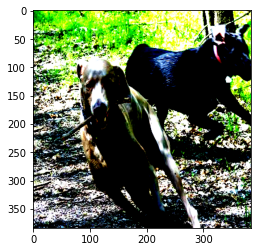

In [ ]:
# Show example
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
img_size = 384

train_transform = transforms.Compose([ 
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

train_loader, train_dataset = getLoader(root_dir=train_image_dir, 
                                         caption_path=train_caption_path, 
                                         data_split = 'train',
                                         vocab_path = "./data/flickr8k/train/vocab.pkl",
                                         word_frequency=5,
                                         transform=train_transform, 
                                         batch_size=32, 
                                         num_workers=0, 
                                         shuffle=True, 
                                         pin_memory=True)

imgs, captions, caplens = next(iter(train_loader))

idx = 1
x = imgs[idx]
y = captions[idx]
print(caplens[idx])
plt.imshow(x.permute(1,2,0))
print(y)
for i in y:
    print(train_dataset.vocab.itos[int(i)],end=" ")

#3. Build Model

## 3.1. Image Encoding


### 3.1.1 CNN Encoder (pretrained)

In [9]:
class CNN_Encoder(nn.Module):
    """
    CNN_Encoder.
    """

    def __init__(self, patch_size=14):
        super(CNN_Encoder, self).__init__()
        self.enc_image_size = patch_size

        resnet = torchvision.models.resnet152(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove the last two layers of Linear and AdaptiveAvgPool2d (we are not doing classificaiton)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Resize image to the defined size of output of this CNN encoder
        self.adaptive_pool = nn.AdaptiveAvgPool2d((patch_size, patch_size))
        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images [batch_size, patch_size=14, patch_size=14, 2048]
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # [batch_size, 2048/512, 8, 8] -> [batch_size, 2048/512, 14, 14]
        out = out.permute(0, 2, 3, 1)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: True to do fine-tuning and False not to do it
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


### 3.1.2 Patch Embedding

In [10]:
class PatchEmbed(nn.Module):
    """Split images into patches and embed them

    Paramters
    ---------
    img_size : int
        Input size(Height or Width) of an image (it is square)
    
    patch_size : int
        Patch size to be splitted
    
    in_chans : int
        Number of channels (1 or gray scale and 3 for RGB)

    Attributes
    ----------
    num_patches : int
        Number of patches per image
    
    embed_dim : int
        Feature dimension

    patches : nn.Conv2d
        Convolution layer that splits an images into patches and embedding them
    """
    def __init__(self, img_size, patch_size = 16, in_chans = 3, embed_dim = 768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.n_patches = (img_size//patch_size)**2
        
        self.patching = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
    def forward(self, x):
        """Run forward pass

        Parmaters
        ---------
        x : torch.Tensor
            Shape: (n_samples, in_chans, img_size, img_size)
        
        Returns
        -------
        torch.Tensor

            Shape : (n_samples, num_patches, embed_dim)
        """
        out = self.patching(x) # (n_samples, embed_dim, H/patch_size, W/patch_size)
        out = out.flatten(2)   # (n_samples, embed_dim, num_patches)
        out = out.permute(0, 2, 1) # (n_samples, num_patches, embed_dim)

        return out


In [11]:
# Example of patching
imgs = torch.ones([3, 3, 384, 384])
img_size = imgs.shape[2]
patch_size = 16
in_chans = imgs.shape[1]
embed_dim = (patch_size**2) * in_chans
patching = PatchEmbed(img_size = img_size, patch_size = patch_size, in_chans = in_chans, embed_dim = embed_dim)

print("Input shape: ", imgs.shape)
afterPatch = patching(imgs)
print("Shapes after Patching: ", afterPatch.shape)
print(f"{afterPatch.shape[0]} : image channels, \n{afterPatch.shape[1]} : number of patches, \n{afterPatch.shape[2]} : embedding dimension")

Input shape:  torch.Size([3, 3, 384, 384])
Shapes after Patching:  torch.Size([3, 576, 768])
3 : image channels, 
576 : number of patches, 
768 : embedding dimension


## 3.2 Transformer (Encoder+Decoder)
https://github.com/RoyalSkye/Image-Caption (2022)

### 3.2.1 Attention and Feed Forward Networks

In [12]:
import torch
from torch import nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
channel_number = 512

class ScaledDotProduct(nn.Module):
    def __init__(self, attn_dim):
        super(ScaledDotProduct, self).__init__()
        self.attn_dim = attn_dim

    def forward(self, Q, K, V, attn_mask):
        """
        :param Q: [batch_size, n_heads, -1(len_q), attn_dim]
        :param K, V: [batch_size, n_heads, -1(len_k=len_v), attn_dim]
        :param attn_mask: [batch_size, n_heads, len_q, len_k]
        """
        # scores: [batch_size, n_heads, len_q, len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.attn_dim)
        # Fills elements of self tensor with value where mask is True.
        scores.to(device).masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)  # [batch_size, n_heads, len_q, len_k]
        context = torch.matmul(attn, V).to(device)  # [batch_size, n_heads, len_q, attn_dim]
        return context, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, Q_dim, K_dim, attn_dim, n_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.Q_Linear = nn.Linear(Q_dim, attn_dim * n_heads).to(device)
        self.K_Linear = nn.Linear(K_dim, attn_dim * n_heads).to(device)
        self.V_Linear = nn.Linear(K_dim, attn_dim * n_heads).to(device)
        self.n_heads = n_heads
        self.attn_dim = attn_dim
        self.embed_dim = Q_dim
        self.dropout = nn.Dropout(p=dropout)
        self.Out = nn.Linear(self.n_heads * self.attn_dim, self.embed_dim).to(device)

    def forward(self, Q, K, V, attn_mask):
        """
        In self-encoder attention:
                Q = K = V: [batch_size, num_pixels=196, encoder_dim=2048]
                attn_mask: [batch_size, len_q=196, len_k=196]
        In self-decoder attention:
                Q = K = V: [batch_size, max_len=52, embed_dim=512]
                attn_mask: [batch_size, len_q=52, len_k=52]
        encoder-decoder attention:
                Q: [batch_size, 52, 512] from decoder
                K, V: [batch_size, 196, 2048] from encoder
                attn_mask: [batch_size, len_q=52, len_k=196]
        return _, attn: [batch_size, n_heads, len_q, len_k]
        """
        residual, batch_size = Q, Q.size(0)
        # q_s: [batch_size, n_heads=8, len_q, attn_dim] k_s/v_s: [batch_size, n_heads=8, len_k, attn_dim]
        q_s = self.Q_Linear(Q).view(batch_size, -1, self.n_heads, self.attn_dim).transpose(1, 2)
        k_s = self.K_Linear(K).view(batch_size, -1, self.n_heads, self.attn_dim).transpose(1, 2)
        v_s = self.V_Linear(V).view(batch_size, -1, self.n_heads, self.attn_dim).transpose(1, 2)
        # attn_mask: [batch_size, self.n_heads, len_q, len_k]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
        # attn: [batch_size, n_heads, len_q, len_k]
        # context: [batch_size, n_heads, len_q, attn_dim]
        context, attn = ScaledDotProduct(self.attn_dim)(q_s, k_s, v_s, attn_mask)
        # context: [batch_size, n_heads, len_q, attn_dim] -> [batch_size, len_q, n_heads * attn_dim]
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.attn_dim).to(device)
        # output: [batch_size, len_q, embed_dim]
        output = self.Out(context)
        output = self.dropout(output)
        return nn.LayerNorm(self.embed_dim).to(device)(output + residual), attn


class FFN(nn.Module):
    def __init__(self, embed_dim, d_ff, dropout):
        super(FFN, self).__init__()
        """
        Two fc layers can also be described by two cnn with kernel_size=1.
        """
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=d_ff, kernel_size=1).to(device)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=embed_dim, kernel_size=1).to(device)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_dim = embed_dim

    def forward(self, inputs):
        """
        encoder: inputs: [batch_size, len_q=196, embed_dim=2048]
        decoder: inputs: [batch_size, max_len=52, embed_dim=512]
        """
        residual = inputs
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        return nn.LayerNorm(self.embed_dim).to(device)(output + residual)


### 3.2.2 Encoder and Decoder

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, dropout, n_heads):
        super(EncoderLayer, self).__init__()
        """
        In "Attention is all you need" paper, dk = dv = 64, h = 8, N=6
        """
        self.enc_self_attn = MultiHeadAttention(Q_dim=2048, K_dim=2048, attn_dim=64, n_heads=n_heads, dropout=dropout)
        self.pos_ffn = FFN(embed_dim=2048, d_ff=4096, dropout=dropout)

    def forward(self, enc_inputs, enc_self_attn_mask):
        """
        :param enc_inputs: [batch_size, num_pixels=196, 2048]
        :param enc_outputs: [batch_size, len_q=196, d_model=2048]
        :return: attn: [batch_size, n_heads=8, 196, 196]
        """
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn


class Encoder(nn.Module):
    def __init__(self, n_layers, dropout, n_heads):
        super(Encoder, self).__init__()
        self.pos_emb = nn.Embedding.from_pretrained(self.get_position_embedding_table(), freeze=True)
        # self.dropout = nn.Dropout(p=dropout)
        self.layers = nn.ModuleList([EncoderLayer(dropout, n_heads) for _ in range(n_layers)])

    def get_position_embedding_table(self):
        def cal_angle(position, hid_idx):
            x = position % 14
            y = position // 14
            x_enc = x / np.power(10000, hid_idx / 1024)
            y_enc = y / np.power(10000, hid_idx / 1024)
            return np.sin(x_enc), np.sin(y_enc)
        def get_posi_angle_vec(position):
            return [cal_angle(position, hid_idx)[0] for hid_idx in range(1024)] + [cal_angle(position, hid_idx)[1] for hid_idx in range(1024)]

        embedding_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(196)])
        return torch.FloatTensor(embedding_table).to(device)

    def forward(self, encoder_out):
        """
        :param encoder_out: [batch_size, num_pixels=196, dmodel=2048]
        """
        batch_size = encoder_out.size(0)
        positions = encoder_out.size(1)
        encoder_out = encoder_out + self.pos_emb(torch.LongTensor([list(range(positions))]*batch_size).to(device))
        # encoder_out = self.dropout(encoder_out)
        # enc_self_attn_mask: [batch_size, 196, 196]
        enc_self_attn_mask = (torch.tensor(np.zeros((batch_size, positions, positions))).to(device)
                              == torch.tensor(np.ones((batch_size, positions, positions))).to(device))
        enc_self_attns = []
        for layer in self.layers:
            encoder_out, enc_self_attn = layer(encoder_out, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return encoder_out, enc_self_attns

class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, dropout, n_heads):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(Q_dim=embed_dim, K_dim=embed_dim, attn_dim=64, n_heads=n_heads, dropout=dropout)
        self.dec_enc_attn = MultiHeadAttention(Q_dim=embed_dim, K_dim=2048, attn_dim=64, n_heads=n_heads, dropout=dropout)
        self.pos_ffn = FFN(embed_dim=embed_dim, d_ff=2048, dropout=dropout)

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        """
        :param dec_inputs: [batch_size, max_len=52, embed_dim=512]
        :param enc_outputs: [batch_size, num_pixels=196, 2048]
        :param dec_self_attn_mask: [batch_size, 52, 52]
        :param dec_enc_attn_mask: [batch_size, 52, 196]
        """
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn


class Decoder(nn.Module):
    def __init__(self, n_layers, vocab_size, max_cap_len, embed_dim, dropout, n_heads):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.max_cap_len = max_cap_len
        self.tgt_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_emb = nn.Embedding.from_pretrained(self.get_position_embedding_table(embed_dim), freeze=True)
        self.dropout = nn.Dropout(p=dropout)
        self.layers = nn.ModuleList([DecoderLayer(embed_dim, dropout, n_heads) for _ in range(n_layers)])
        self.projection = nn.Linear(embed_dim, vocab_size, bias=False).to(device)

    def get_position_embedding_table(self, embed_dim):
        def cal_angle(position, hid_idx):
            return position / np.power(10000, 2 * (hid_idx // 2) / embed_dim)
        def get_posi_angle_vec(position):
            return [cal_angle(position, hid_idx) for hid_idx in range(embed_dim)]

        embedding_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(52)])
        embedding_table[:, 0::2] = np.sin(embedding_table[:, 0::2])  # dim 2i
        embedding_table[:, 1::2] = np.cos(embedding_table[:, 1::2])  # dim 2i+1
        return torch.FloatTensor(embedding_table).to(device)

    def get_attn_pad_mask(self, seq_q, seq_k):
        batch_size, len_q = seq_q.size()
        batch_size, len_k = seq_k.size()
        # In wordmap, <pad>:0
        # pad_attn_mask: [batch_size, 1, len_k], one is masking
        pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
        return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

    def get_attn_subsequent_mask(self, seq):
        attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
        subsequent_mask = np.triu(np.ones(attn_shape), k=1)
        subsequent_mask = torch.from_numpy(subsequent_mask).byte().to(device)
        return subsequent_mask

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :param encoder_out: [batch_size, num_pixels=196, 2048]
        :param encoded_captions: [batch_size, 52]
        :param caption_lengths: [batch_size, 1]
        """
        batch_size = encoder_out.size(0)
        # Sort input data by decreasing lengths.
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # dec_outputs: [batch_size, max_len=52, embed_dim=512]
        # dec_self_attn_pad_mask: [batch_size, len_q=52, len_k=52], 1 if id=0(<pad>)
        # dec_self_attn_subsequent_mask: [batch_size, 52, 52], Upper triangle of an array with 1.
        # dec_self_attn_mask for self-decoder attention, the position whose val > 0 will be masked.
        # dec_enc_attn_mask for encoder-decoder attention.
        # e.g. 9488, 23, 53, 74, 0, 0  |  dec_self_attn_mask:
        # 0 1 1 1 2 2
        # 0 0 1 1 2 2
        # 0 0 0 1 2 2
        # 0 0 0 0 2 2
        # 0 0 0 0 1 2
        # 0 0 0 0 1 1
        dec_outputs = self.tgt_emb(encoded_captions) + self.pos_emb(torch.LongTensor([list(range(52))]*batch_size).to(device))
        dec_outputs = self.dropout(dec_outputs)
        dec_self_attn_pad_mask = self.get_attn_pad_mask(encoded_captions, encoded_captions)
        dec_self_attn_subsequent_mask = self.get_attn_subsequent_mask(encoded_captions)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)
        dec_enc_attn_mask = (torch.tensor(np.zeros((batch_size, 52, 196))).to(device) == torch.tensor(np.ones((batch_size, 52, 196))).to(device))

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # attn: [batch_size, n_heads, len_q, len_k]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, encoder_out, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        predictions = self.projection(dec_outputs)
        return predictions, encoded_captions, decode_lengths, sort_ind, dec_self_attns, dec_enc_attns

### 3.3.3 Transformer

In [14]:
class Transformer(nn.Module):
    """
    See paper 5.4: "Attention Is All You Need" - https://arxiv.org/abs/1706.03762
    "Apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
    In addition, apply dropout to the sums of the embeddings and the positional encodings in both the encoder
    and decoder stacks." (Now, we dont't apply dropout to the encoder embeddings)
    """
    def __init__(self, vocab_size, max_cap_len, embed_dim, encoder_layers, decoder_layers, dropout=0.1, n_heads=8):
        super(Transformer, self).__init__()
        self.encoder = Encoder(encoder_layers, dropout, n_heads)
        self.decoder = Decoder(decoder_layers, vocab_size, max_cap_len, embed_dim, dropout, n_heads)
        self.embedding = self.decoder.tgt_emb

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def forward(self, enc_inputs, encoded_captions, caption_lengths):
        """
        preprocess: enc_inputs: [batch_size, 14, 14, 2048]/[batch_size, 196, 2048] -> [batch_size, 196, 2048]
        encoded_captions: [batch_size, 52]
        caption_lengths: [batch_size, 1], not used
        The encoder or decoder is composed of a stack of n_layers=6 identical layers.
        One layer in encoder: Multi-head Attention(self-encoder attention) with Norm & Residual
                            + Feed Forward with Norm & Residual
        One layer in decoder: Masked Multi-head Attention(self-decoder attention) with Norm & Residual
                            + Multi-head Attention(encoder-decoder attention) with Norm & Residual
                            + Feed Forward with Norm & Residual
        """
        batch_size = enc_inputs.size(0)
        encoder_dim = enc_inputs.size(-1)
        enc_inputs = enc_inputs.view(batch_size, -1, encoder_dim)

        encoder_out, enc_self_attns = self.encoder(enc_inputs)
        # encoder_out: [batch_size, 196, 2048]
        predictions, encoded_captions, decode_lengths, sort_ind, dec_self_attns, dec_enc_attns = self.decoder(encoder_out, encoded_captions, caption_lengths)
        alphas = {"enc_self_attns": enc_self_attns, "dec_self_attns": dec_self_attns, "dec_enc_attns": dec_enc_attns}
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

#4. Train the model

## 4.1. Functions

### 4.1.1. utils

In [15]:
import os
import numpy as np
import json
import torch
# from scipy.misc import imread, imresize
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
import imageio
from PIL import Image
# from eval_func.spice.spice import Spice


def init_embedding(embeddings):
    """
    Fills embedding tensor with values from the uniform distribution.
    :param embeddings: embedding tensor
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.
    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """

    # Find embedding dimension
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Create tensor to hold embeddings, initialize
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Read embedding file
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Ignore word if not in train_vocab
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(filename, epoch, epochs_since_improvement, encoder, decoder, encoder_state_dict, decoder_state_dict, encoder_optimizer, decoder_optimizer,
                    encoder_optimizer_state_dict, decoder_optimizer_state_dict, metrics, word_map, rev_word_map, final_config):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param word_map: word map from string to integer
    :param rev_word_map: reverse word map from integer to string
    :param final_args: final configuration
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'metrics': metrics,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_state_dict': encoder_state_dict,
             'decoder_state_dict': decoder_state_dict,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer,
             'encoder_optimizer_state_dict': encoder_optimizer_state_dict, 
             'decoder_optimizer_state_dict': decoder_optimizer_state_dict, 
             'word_map': word_map,
             'rev_word_map': rev_word_map,
             'final_config': final_config}

    torch.save(state, filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

def convert2words(sequences, rev_word_map):
    for l1 in sequences:
        caption = ""
        for l2 in l1:
            caption += rev_word_map[l2]
            caption += " "
        print(caption)

### 4.1.2 Train

In [16]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import argparse
import codecs
import numpy as np
import datasets

def train(config, train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        # imgs: [batch_size, 14, 14, 2048]
        # caps: [batch_size, 52]
        # caplens: [batch_size, 1]
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        # print(scores.size())
        # print(targets.size())

        # Calculate loss
        loss = criterion(scores, targets)
        # Add doubly stochastic attention regularization
        # Second loss, mentioned in paper "Show, Attend and Tell: Neural Image Caption Generation with Visual Attention"
        # https://arxiv.org/abs/1502.03044
        # In section 4.2.1 Doubly stochastic attention regularization: We know the weights sum to 1 at a given timestep.
        # But we also encourage the weights at a single pixel p to sum to 1 across all timesteps T.
        # This means we want the model to attend to every pixel over the course of generating the entire sequence.
        # Therefore, we want to minimize the difference between 1 and the sum of a pixel's weights across all timesteps.
        dec_alphas = alphas["dec_enc_attns"]
        alpha_trans_c = config.alpha_c / (config.n_heads * config.decoder_layers)
        for layer in range(config.decoder_layers):  # config.decoder_layers = len(dec_alphas)
            cur_layer_alphas = dec_alphas[layer]  # [batch_size, n_heads, 52, 196]
            for h in range(config.n_heads):
                cur_head_alpha = cur_layer_alphas[:, h, :, :]
                loss += alpha_trans_c * ((1. - cur_head_alpha.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if config.grad_clip is not None:
            clip_gradient(decoder_optimizer, config.grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, config.grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)
        start = time.time()
        if i % config.print_freq == 0:
            print("Epoch: {}/{} step: {}/{} Loss: {} AVG_Loss: {} Top-5 Accuracy: {} Batch_time: {}s".format(epoch+1, config.epochs, i+1, len(train_loader), losses.val, losses.avg, top5accs.val, batch_time.val))
    return losses.avg, top5accs.avg, batch_time.avg


def validate(config, val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: average loss, top5 accuracy, and batch time. sacrebleu_score
    score_dict {'Bleu_1': 0., 'Bleu_2': 0., 'Bleu_3': 0., 'Bleu_4': 0., 'METEOR': 0., 'ROUGE_L': 0., 'CIDEr': 1.}
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating Bleu scores
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaptions) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            dec_alphas = alphas["dec_enc_attns"]
            alpha_trans_c = config.alpha_c / (config.n_heads * config.decoder_layers)
            for layer in range(config.decoder_layers):  # config.decoder_layers = len(dec_alphas)
                cur_layer_alphas = dec_alphas[layer]  # [batch_size, n_heads, 52, 196]
                for h in range(config.n_heads):
                    cur_head_alpha = cur_layer_alphas[:, h, :, :]
                    loss += alpha_trans_c * ((1. - cur_head_alpha.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)
            start = time.time()
            
            # For Bleu Score
            ## References for Bleu score
            allcaptions = allcaptions[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaptions.shape[0]):
                img_caps = allcaptions[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<SOS>'], word_map['<PAD>']}], img_caps)) # remove <SOS> and pads
                references.append(img_captions)

            ## Hypotheses for Bleu score
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for idx, p in enumerate(preds):
                temp_preds.append(preds[idx][:decode_lengths[idx]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

    sacrebleu = datasets.load_metric("sacrebleu")
    sacrebleu_score = sacrebleu.compute(predictions=hypotheses, references=references)

    print("EVA LOSS: {} TOP-5 Accuracy {} SacreBleu Score {}".format(losses.avg, top5accs.avg, sacrebleu_score['score']))

    return losses.avg, top5accs.avg, batch_time.avg, sacrebleu_score

## 4.2 Train and Validate

### 4.2.1 Configuration

In [17]:
class Config(object):
    def __init__(self):
        # Load Data
        self.img_size = 256
        self.emb_dim = 300
        self.attention_dim=512
        self.decoder_dim=512
        self.n_heads = 8
        self.dropout =0.1
        self.encoder_layers=6
        self.decoder_layers=12

        # Training parameters
        self.start_epoch = 0
        self.epochs = 40
        self.max_cap_len = 50
        self.stop_criteria = 25
        self.batch_size = 32
        self.print_freq = 100
        self.workers = 4
        self.encoder_lr = 1e-4
        self.decoder_lr = 1e-6
        self.grad_clip = 5.
        self.alpha_c = 1.
        self.fine_tune_encoder = False
        self.fine_tune_embedding = False
        self.checkpoint = None
        self.embedding_path = os.path.join("./data", "glove.6B.300d.txt")

        # Save the model and the result
        self.continue_train = True
        self.load_model = False
        self.load_model4eval = True
        self.save_model= True
        self.checkpoint_path = "./checkpoint/" # model path that learned models will be saved
        self.checkpoint_name = "ImageCaption_TR_220818_continued.pth.tar"

        # Data folders
        self.train_image_dir = './data/flickr8k/train/Images' # train images folder
        self.val_image_dir = './data/flickr8k/val/Images' # validation images folder
        self.test_image_dir = './data/flickr8k/test/Images' # test images folder
        self.train_caption_path = "./data/flickr8k/train/captions.txt" # train images captions
        self.val_caption_path = "./data/flickr8k/val/captions.txt" # validation images captions
        self.test_caption_path = "./data/flickr8k/test/captions.txt" # test images captions
        self.vocab_path = "./data/flickr8k/train/vocab.pkl"

In [18]:
config = Config()
# load checkpoint, these parameters can't be modified
final_args = {"emb_dim": config.emb_dim,
            "attention_dim": config.attention_dim,
            "decoder_dim": config.decoder_dim,
            "n_heads": config.n_heads,
            "dropout": config.dropout,
            "encoder_layers": config.encoder_layers,
            "decoder_layers": config.decoder_layers}

In [19]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
train_transform = transforms.Compose([ 
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

val_transform = transforms.Compose([ 
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([ 
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])
    
num_workers = 4 if torch.cuda.is_available() else 0 #colab gpu allows up to 4 workers. laptop cpu only allows 0 worker
word_frequency = 5

train_loader, train_dataset = getLoader(root_dir=config.train_image_dir, 
                                            caption_path = config.train_caption_path, 
                                            data_split = 'train',
                                            vocab_path = config.vocab_path,
                                            word_frequency = word_frequency,
                                            max_cap_len = config.max_cap_len,
                                            transform=train_transform, 
                                            batch_size=config.batch_size, 
                                            num_workers=num_workers, 
                                            shuffle=True, 
                                            pin_memory=True)

val_loader, val_dataset = getLoader(root_dir=config.val_image_dir, 
                                            caption_path=config.val_caption_path, 
                                            data_split = 'val',
                                            vocab_path = config.vocab_path,
                                            word_frequency=word_frequency, 
                                            max_cap_len = config.max_cap_len,                                   
                                            transform=val_transform, 
                                            batch_size=config.batch_size, 
                                            num_workers=num_workers, 
                                            shuffle=True, 
                                            pin_memory=True)

test_loader, test_dataset = getLoader(root_dir=config.test_image_dir, 
                                            caption_path=config.test_caption_path, 
                                            data_split = 'test',
                                            vocab_path = config.vocab_path,
                                            word_frequency=word_frequency, 
                                            max_cap_len = config.max_cap_len,                                     
                                            transform=test_transform, 
                                            batch_size=1, 
                                            num_workers=num_workers, 
                                            shuffle=True, 
                                            pin_memory=True)

In [20]:
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
best_bleu4 = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Read word map
word_map = train_dataset.vocab.stoi
rev_word_map = train_dataset.vocab.itos

# Initialize / load checkpoint
if config.checkpoint is None:
    encoder = CNN_Encoder()
    encoder.fine_tune(config.fine_tune_encoder)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                        lr=config.encoder_lr) if config.fine_tune_encoder else None

    decoder = Transformer(vocab_size=len(word_map), embed_dim=config.emb_dim, max_cap_len = config.max_cap_len, 
                        encoder_layers=config.encoder_layers, decoder_layers=config.decoder_layers, dropout=config.dropout,
                        n_heads=config.n_heads)

    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=config.decoder_lr)

        # load pre-trained word embedding
    if config.embedding_path is not None:
        all_word_embeds = {}
        for i, line in enumerate(codecs.open(config.embedding_path, 'r', 'utf-8')):
            s = line.strip().split()
            all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

        # change emb_dim
        config.emb_dim = list(all_word_embeds.values())[-1].size
        word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_map), config.emb_dim))
        for w in word_map:
            if w in all_word_embeds:
                word_embeds[word_map[w]] = all_word_embeds[w]
            elif w.lower() in all_word_embeds:
                word_embeds[word_map[w]] = all_word_embeds[w.lower()]
            else:
                # <pad> <start> <end> <unk>
                embedding_i = torch.ones(1, config.emb_dim)
                torch.nn.init.xavier_uniform_(embedding_i)
                word_embeds[word_map[w]] = embedding_i

        word_embeds = torch.FloatTensor(word_embeds).to(device)
        decoder.load_pretrained_embeddings(word_embeds)
        decoder.fine_tune_embeddings(config.fine_tune_embedding)
        print('Loaded {} pre-trained word embeddings.'.format(len(word_embeds)))

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)
    print("encoder_layers {} decoder_layers {} n_heads {} dropout {} encoder_lr {} "
          "decoder_lr {} alpha_c {}".format(config.encoder_layers, config.decoder_layers, config.n_heads, config.dropout,
                                            config.encoder_lr, config.decoder_lr, config.alpha_c))
    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

metrics = {}
metrics['train_losses'] = []
metrics['train_accs'] = []
metrics['train_times'] = []
metrics['val_losses'] = []
metrics['val_accs'] = []
metrics['val_times'] = []

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Loaded 2544 pre-trained word embeddings.
encoder_layers 6 decoder_layers 12 n_heads 8 dropout 0.1 encoder_lr 0.0001 decoder_lr 1e-06 alpha_c 1.0


In [ ]:
if config.continue_train:

    checkpoint_path = "./checkpoint/" # model path that learned models will be saved
    checkpoint_name = "ImageCaption_TR_220818.pth.tar"

    checkpoint_filename = os.path.join(checkpoint_path, checkpoint_name)
    # Load model
    checkpoint = torch.load(checkpoint_filename, map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)

    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder_optimizer = checkpoint['decoder_optimizer']
    config.start_epoch = checkpoint['epoch'] + 1
    metrics = checkpoint['metrics']

In [ ]:
# Epochs
for epoch in range(config.start_epoch, config.start_epoch+config.epochs):

    # Decay learning rate if there is no improvement for 5 consecutive epochs, and terminate train training after 25
    if epochs_since_improvement == config.stop_criteria:
        print("the model has not improved in the last {} epochs".format(config.stop_criteria))
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 5 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if config.fine_tune_encoder and encoder_optimizer is not None:
            print(encoder_optimizer)
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    train_loss, train_acc, train_time = train(config, train_loader=train_loader, encoder=encoder, decoder=decoder, criterion=criterion, 
                                              encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, epoch=epoch)
    metrics['train_losses'].append(train_loss)
    metrics['train_accs'].append(train_acc)
    metrics['train_times'].append(train_time)

    # One epoch's validation
    val_loss, val_acc, val_time, sacrebleu_score = validate(config, val_loader=val_loader, encoder=encoder, decoder=decoder, criterion=criterion)
    metrics['val_losses'].append(val_loss) 
    metrics['val_accs'].append(val_acc)
    metrics['val_times'].append(val_time)

    recent_bleu4 = sacrebleu_score['precisions'][3]

    # Check if there was an improvement
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0

    enc_state_dict = encoder.state_dict() if encoder is not None else None
    dec_state_dict = decoder.state_dict() if decoder is not None else None
    enc_optim_state_dict = encoder_optimizer.state_dict() if encoder_optimizer is not None else None
    dec_optim_state_dict = decoder_optimizer.state_dict() if decoder_optimizer is not None else None
    
    # Save checkpoint
    if config.save_model:
        save_checkpoint_path = os.path.join(config.checkpoint_path, config.checkpoint_name)
        save_checkpoint(save_checkpoint_path, epoch, epochs_since_improvement, encoder, decoder, enc_state_dict, dec_state_dict, encoder_optimizer,
                        decoder_optimizer, enc_optim_state_dict, dec_optim_state_dict, metrics, word_map, rev_word_map, final_args)

Epoch: 29/40 step: 1/938 Loss: 4.172850131988525 AVG_Loss: 4.172850131988525 Top-5 Accuracy: 58.8235294117647 Batch_time: 90.63204050064087s
Epoch: 29/40 step: 101/938 Loss: 4.1015143394470215 AVG_Loss: 4.198696100687516 Top-5 Accuracy: 60.638297872340424 Batch_time: 10.253109216690063s
Epoch: 29/40 step: 201/938 Loss: 4.49467658996582 AVG_Loss: 4.1975513686098305 Top-5 Accuracy: 55.67282321899736 Batch_time: 2.4670729637145996s
Epoch: 29/40 step: 301/938 Loss: 4.077316761016846 AVG_Loss: 4.192046086973016 Top-5 Accuracy: 61.51603498542274 Batch_time: 2.417344093322754s
Epoch: 29/40 step: 401/938 Loss: 4.411017417907715 AVG_Loss: 4.19008357819404 Top-5 Accuracy: 59.020618556701024 Batch_time: 2.4867889881134033s
Epoch: 29/40 step: 501/938 Loss: 4.162079811096191 AVG_Loss: 4.185456700652369 Top-5 Accuracy: 59.43152454780361 Batch_time: 2.4932379722595215s
Epoch: 29/40 step: 601/938 Loss: 4.293676853179932 AVG_Loss: 4.1829804924056475 Top-5 Accuracy: 59.146341463414636 Batch_time: 2.4848

EVA LOSS: 4.292628625059499 TOP-5 Accuracy 57.88861544685298 SacreBleu Score 45.06147024304982
Epoch: 30/40 step: 1/938 Loss: 4.169046401977539 AVG_Loss: 4.169046401977539 Top-5 Accuracy: 59.03954802259887 Batch_time: 3.232707977294922s
Epoch: 30/40 step: 101/938 Loss: 4.150279521942139 AVG_Loss: 4.153329598335285 Top-5 Accuracy: 63.069544364508396 Batch_time: 2.4947218894958496s
Epoch: 30/40 step: 201/938 Loss: 4.241313934326172 AVG_Loss: 4.146187693734707 Top-5 Accuracy: 57.99457994579945 Batch_time: 2.4973042011260986s
Epoch: 30/40 step: 301/938 Loss: 4.333608150482178 AVG_Loss: 4.1541850422223 Top-5 Accuracy: 59.016393442622956 Batch_time: 2.5069079399108887s
Epoch: 30/40 step: 401/938 Loss: 4.241279602050781 AVG_Loss: 4.152133325895775 Top-5 Accuracy: 58.1578947368421 Batch_time: 2.5067460536956787s
Epoch: 30/40 step: 501/938 Loss: 4.20697546005249 AVG_Loss: 4.151380901862502 Top-5 Accuracy: 60.957178841309826 Batch_time: 2.503108501434326s
Epoch: 30/40 step: 601/938 Loss: 4.00013

In [ ]:
sacrebleu_score

In [ ]:
epochs = list(range(1, len(metrics['train_losses'])+1))
ax1 = plt.subplot()
l1 = ax1.plot(epochs, metrics['train_losses'], color='red', label='train loss')
l2 = ax1.plot(epochs, metrics['val_losses'], color='blue', label='val loss')
plt.legend(loc='lower right')
ax2 = ax1.twinx()
l3 = ax2.plot(epochs, metrics['train_accs'], color='orange', label='train acc')
l4 = ax2.plot(epochs, metrics['val_accs'], color='green', label='val acc')
plt.legend(loc='upper right')
plt.title('Transformer Image Captionoing')
plt.show()
print(f"Loss {metrics['train_losses'][4]:.2} at 5th, {metrics['train_losses'][9]:.2} at 10th, {metrics['train_losses'][14]:.2} at 15th")
print(f"Loss {metrics['val_losses'][4]:.2} at 5th, {metrics['val_losses'][9]:.2} at 10th, {metrics['val_losses'][14]:.2} at 15th")
print("")
print(f"Accuracy {metrics['train_accs'][4]:.2} at 5th, {metrics['train_accs'][9]:.2} at 10th, {metrics['train_accs'][14]:.2} at 15th")
print(f"Accuracy {metrics['val_accs'][4]:.2} at 5th, {metrics['val_accs'][9]:.2} at 10th, {metrics['val_accs'][14]:.2} at 15th")

#5. Evaluation

In [21]:
# For evaluation
if config.load_model4eval is True:
    checkpoint_filename = os.path.join(config.checkpoint_path, config.checkpoint_name)
    checkpoint = torch.load(checkpoint_filename, map_location=str(device))
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder_optimizer = checkpoint['decoder_optimizer']
    config.start_epoch = checkpoint['epoch'] + 1
    metrics = checkpoint['metrics']

encoder.eval()
decoder.eval()
word_map = test_dataset.vocab.stoi
references = list()
hypotheses = list()


In [23]:
beam_size = 3
Caption_End = False
word_map = test_dataset.vocab.stoi
rev_word_map = test_dataset.vocab.itos
vocab_size = len(word_map)

references = list()
hypotheses = list()

with torch.no_grad():
    for i, (imgs, captions, caplens, allcaptions) in enumerate(tqdm(test_loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):
        k = beam_size
        imgs = imgs.to(device)
        
        # Encode
        encoder_out = encoder(imgs) #[batch_size=1, enc_image_size=14, enc_image_size=14, enc_embed_dim=2048]
        enc_img_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten Encoding        
        #Expand encoder_out to the beam size, se we treat the problem as having a batch size of 3
        encoder_out = encoder_out.expand(k, enc_img_size, enc_img_size, encoder_dim) #[k=3, enc_image_size=14, enc_image_size=14, enc_embed_dim=2048]
        k_prev_words = torch.LongTensor([[word_map['<SOS>']]*captions.size(1)] * k).to(device) #[k=3, each_caption_length = 52]
        
        # Tensor to store top k sequences; now they're just <SOS>
        seqs = torch.LongTensor([[word_map['<SOS>']]] * k).to(device)  # (k=3, 1)
        
        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)
        
        # Lists to store completed sequences and scores
        complete_seqs = []
        complete_seqs_scores = []
        step = 1

        # Start decoding
        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:
            # print("steps {} k_prev_words: {}".format(step, k_prev_words))
            # cap_len = torch.LongTensor([52]).repeat(k, 1).to(device) may cause different sorted results on GPU/CPU in transformer.py
            cap_len = torch.LongTensor([config.max_cap_len+2]).repeat(k, 1)  # [s, 1]
            scores, _, _, _, _ = decoder(encoder_out, k_prev_words, cap_len)
            scores = scores[:, step-1, :].squeeze(1)  # [s, 1, vocab_size] -> [s, vocab_size]
            scores = F.log_softmax(scores, dim=1)
            # top_k_scores: [s, 1]
            scores = top_k_scores.expand_as(scores) + scores  # [s, vocab_size]
            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words // vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
            # Which sequences are incomplete (didn't reach <EOS>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                                next_word != word_map['<EOS>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            # Set aside complete sequences
            if len(complete_inds) > 0:
                Caption_End = True
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly
            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            # Important: this will not work, since decoder has self-attention
            # k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1).repeat(k, 52)
            k_prev_words = k_prev_words[incomplete_inds]
            k_prev_words[:, :step+1] = seqs  # [s, 52]
            # k_prev_words[:, step] = next_word_inds[incomplete_inds]  # [s, 52]
            # Break if things have been going on too long
            if step > 50:
                break
            step += 1

        # choose the caption which has the best_score.
        assert Caption_End
        if len(complete_seqs_scores) > 0:
            indices = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[indices]
        else:
            seq = [1, 2]

        # References
        img_caps = allcaptions[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<SOS>'], word_map['<EOS>'], word_map['<PAD>']}], img_caps)) # remove <SOS> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<SOS>'], word_map['<EOS>'], word_map['<PAD>']}])
        
sacrebleu = datasets.load_metric("sacrebleu")
sacrebleu_score = sacrebleu.compute(predictions=hypotheses, references=references)
sacrebleu_score

EVALUATING AT BEAM SIZE 3: 100%|██████████| 5455/5455 [1:44:35<00:00,  1.15s/it]


{'score': 47.525109273479906,
 'counts': [102185, 73460, 53450, 33355],
 'totals': [135595, 130140, 124685, 119230],
 'precisions': [75.36044839411483,
  56.44690333487014,
  42.86802742912138,
  27.975341776398558],
 'bp': 1.0,
 'sys_len': 135595,
 'ref_len': 124425}

In [24]:
hypotheses_filename = "./hypotheses_220820.pkl"
reference_filename = "./reference_220820.pkl"
pred_path = os.path.join(config.checkpoint_path, hypotheses_filename)
ref_path = pred_path = os.path.join(config.checkpoint_path, reference_filename)

with open(pred_path, 'wb') as f:
    pickle.dump(hypotheses, f)

with open(ref_path, 'wb') as f:
    pickle.dump(references, f)


def convert2words(predictions_idx, rev_word_map):
    predictions_words = list()
    for l1 in predictions_idx:
        caption = ""
        for l2 in l1:
            caption += rev_word_map[l2]
            caption += " "
        predictions_words.append(caption)
    return predictions_words

predictions = convert2words(hypotheses, rev_word_map)
answers = list()
for reference in references:
    answers.append(convert2words(reference, rev_word_map))

In [25]:
predictions[1]

'a man and a girl are standing in the grass '

In [26]:
answers[1]

['a woman and child are holding hands walking up a grassy hill on a fair day ',
 'a woman and child walking uphill ',
 'a woman and young girl climbing a grassy hill ',
 'a woman with her sweatshirt tied around her waist holding hands with a young girl in a green shirt as they walk up a grassy hill ',
 'an adult and a child hold hands as they walk up a grassy hill ']

#6. Image Caption

In [27]:
# Load the model
config = Config()

In [28]:
checkpoint['word_map'] = train_dataset.vocab.stoi
checkpoint['rev_word_map'] = train_dataset.vocab.itos

In [29]:
import cv2
from google.colab.patches import cv2_imshow

# Generate a caption
def convert2words(predictions_idx, rev_word_map):
    predictions_words = list()
    for l1 in predictions_idx:
        caption = ""
        for l2 in l1:
            caption += rev_word_map[l2]
            caption += " "
        predictions_words.append(caption)
    return predictions_words

def generateCaption(image_filename, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the checkpoint
    checkpoint_filename = os.path.join(config.checkpoint_path, config.checkpoint_name)
    checkpoint = torch.load(checkpoint_filename, map_location=str(device))

    encoder = checkpoint['encoder']
    decoder = checkpoint['decoder']
    #word_map = checkpoint['word_map']
    #rev_word_map = checkpoint['rev_word_map']
    word_map = train_dataset.vocab.stoi
    rev_word_map = train_dataset.vocab.itos

    # Load the image and transform to the size to work with [1, ]
    image = cv2.imread(image_filename)
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

    test_transform = transforms.Compose([ 
        transforms.ToPILImage(),
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)])

    img = test_transform(image)
    img = img.unsqueeze(0)

    # Prepare encoder and decoder
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    encoder.eval()
    decoder.eval()

    vocab_size = len(word_map)
    beam_size = 5
    Caption_End = False

    hypotheses = list()

    with torch.no_grad():
        k = beam_size
        img = img.to(device)
        
        # Encode
        encoder_out = encoder(img) #[batch_size=1, enc_image_size=14, enc_image_size=14, enc_embed_dim=2048]
        enc_img_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)
       
        #Expand encoder_out to the beam size, se we treat the problem as having a batch size of 3
        encoder_out = encoder_out.expand(k, enc_img_size, enc_img_size, encoder_dim) #[k=3, enc_image_size=14, enc_image_size=14, enc_embed_dim=2048]
        k_prev_words = torch.LongTensor([[word_map['<SOS>']]*(config.max_cap_len+2)] * k).to(device) #[k=3, each_caption_length = 52]
        
        # Tensor to store top k sequences; now they're just <SOS>
        seqs = torch.LongTensor([[word_map['<SOS>']]] * k).to(device)  # (k=3, 1)
        
        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)
        
        # Lists to store completed sequences and scores
        complete_seqs = []
        complete_seqs_scores = []
        step = 1

        # Start decoding
        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:
            # print("steps {} k_prev_words: {}".format(step, k_prev_words))
            # cap_len = torch.LongTensor([52]).repeat(k, 1).to(device) may cause different sorted results on GPU/CPU in transformer.py
            cap_len = torch.LongTensor([config.max_cap_len+2]).repeat(k, 1)  # [s, 1]
            scores, _, _, _, _ = decoder(encoder_out, k_prev_words, cap_len)
            scores = scores[:, step-1, :].squeeze(1)  # [s, 1, vocab_size] -> [s, vocab_size]
            scores = F.log_softmax(scores, dim=1)
            # top_k_scores: [s, 1]
            scores = top_k_scores.expand_as(scores) + scores  # [s, vocab_size]
            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words // vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
            # Which sequences are incomplete (didn't reach <EOS>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                                next_word != word_map['<EOS>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            # Set aside complete sequences
            if len(complete_inds) > 0:
                Caption_End = True
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly
            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            # Important: this will not work, since decoder has self-attention
            # k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1).repeat(k, 52)
            k_prev_words = k_prev_words[incomplete_inds]
            k_prev_words[:, :step+1] = seqs  # [s, 52]
            # k_prev_words[:, step] = next_word_inds[incomplete_inds]  # [s, 52]
            # Break if things have been going on too long
            if step > 50:
                break
            step += 1

        # choose the caption which has the best_score.
        assert Caption_End
        if len(complete_seqs_scores) > 0:
            indices = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[indices]
        else:
            seq = [1, 2]
        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<SOS>'], word_map['<EOS>'], word_map['<PAD>']}])
    
    predictions = convert2words(hypotheses, rev_word_map)

    resizedImage = cv2.resize(image, (config.img_size, config.img_size))
    cv2_imshow(resizedImage)
    print(prediction[0])
    return predictions


./data/images/Innovative-picnic-ideas.jpeg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


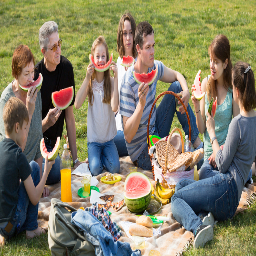

NameError: ignored

In [30]:
image_path = './data/images'
image_name = 'Innovative-picnic-ideas.jpeg'
image_filename = os.path.join(image_path, image_name)
print(image_filename)

config = Config()

prediction = generateCaption(image_filename, config)